In [1]:
!pip install matplotlib
!pip install numpy
!pip install torch torchvision
!pip install av
!pip install pandas
!pip install opencv-python-headless
!pip install torchinfo
!pip install tensorboard



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [7]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# matplotlib
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms

# misc
import time
from datetime import datetime
from torchinfo import summary

# preprocessing
import av
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# logging
import os
import logging
from torch.utils.tensorboard import SummaryWriter
import zipfile


In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
try:
    import mediapipe as mp
except:
    !pip install mediapipe
    import mediapipe as mp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [11]:
# create relevant directories

# create dir to save logs if it does not exist
if not os.path.exists("log"):
    os.mkdir("log")

# create dir to save runs if it does not exist
if not os.path.exists("runs"):
    os.mkdir("runs")

# create dir to save models if it does not exist
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")

In [12]:
log_path = "log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
sum_path = "runs/cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())

# Log to file & tensorboard writer
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('signo-lingo')
logger.info('Logging to file...')
writer = SummaryWriter(sum_path)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
data_dir = '/content/drive/MyDrive/data/data'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'


In [15]:
root_path = '/content/drive/MyDrive/data/data'

train_path = [os.path.join('{}/train'.format(root_path), f) for f in os.listdir('{}/train'.format(root_path))]
val_path = [os.path.join('{}/val'.format(root_path), f) for f in os.listdir('{}/val'.format(root_path))]
test_path = [os.path.join('{}/test'.format(root_path), f) for f in os.listdir('{}/test'.format(root_path))]

In [16]:
# All labels
train_label_df = pd.read_csv(r'{}/filtered_train_labels.csv'.format(root_path), header=None)
test_label_df = pd.read_csv(r'{}/filtered_test_labels.csv'.format(root_path), header=None)
val_label_df = pd.read_csv(r'{}/filtered_val_labels.csv'.format(root_path), header=None)

# convert all into hashmap - key = u_vid_name , value = label

train_label = {k[0]: k[1] for k in train_label_df.values.tolist()}
print(train_label)
test_label = {k[0]: k[1] for k in test_label_df.values.tolist()}
val_label = {k[0]: k[1] for k in val_label_df.values.tolist()}

{'signer0_sample1': 41, 'signer0_sample2': 104, 'signer0_sample3': 205, 'signer0_sample4': 26, 'signer0_sample5': 191, 'signer0_sample6': 140, 'signer0_sample7': 139, 'signer0_sample8': 225, 'signer0_sample9': 102, 'signer0_sample10': 19, 'signer0_sample11': 160, 'signer0_sample12': 143, 'signer0_sample13': 215, 'signer0_sample14': 130, 'signer0_sample15': 166, 'signer0_sample16': 5, 'signer0_sample17': 28, 'signer0_sample18': 162, 'signer0_sample19': 202, 'signer0_sample20': 76, 'signer0_sample21': 66, 'signer0_sample22': 147, 'signer0_sample23': 183, 'signer0_sample24': 201, 'signer0_sample25': 1, 'signer0_sample26': 145, 'signer0_sample27': 127, 'signer0_sample28': 177, 'signer0_sample29': 5, 'signer0_sample30': 8, 'signer0_sample31': 205, 'signer0_sample32': 150, 'signer0_sample33': 53, 'signer0_sample34': 116, 'signer0_sample35': 71, 'signer0_sample36': 224, 'signer0_sample37': 118, 'signer0_sample38': 97, 'signer0_sample39': 63, 'signer0_sample40': 59, 'signer0_sample41': 47, 'si

In [110]:
# # Total label + turkish to english translation

total_label = pd.read_csv(r'{}/ClassId.csv'.format(root_path))
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)

total unique label: 226


In [18]:
def pose_styling(inp_arr):
    # Set up drawing and holistic
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic

    mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2)

    # Drawing image
    pose_arr = []
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for image in inp_arr:
            results = holistic.process(image)

            # 1. Draw face landmarks
            mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                     mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                     )

            # 2. Right hand
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                     mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                                     )

            # 3. Left Hand
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                     mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                                     )

            # 4. Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                                     )

            pose_arr.append(image)
    return pose_arr

In [19]:
# pick fix frames
'''
e.g.
input_frame = 5, output_frame = 3

steps 1. create an array and multiply each frame by output factor
    [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]

step 2. Divide by output section
    [1, 1, 1, 2, 2, | 2, 3, 3, 3, 4, | 4, 4, 5, 5, 5]

step 3. Find the center index to pick
    5 // 2 = 2

step 4. Select center index from each section
    [1, 1*, 1, 2, 2, | 2, 3*, 3, 3, 4, | 4, 4*, 5, 5, 5]

step 5. Return a set of those index
    set([1, 3, 4])
'''
def fix_frame(input_frame: int, output_frame: int) -> set:
    '''
    input
        - number of input frames
        - number of output frames
    output
        - a set of frames
    '''
    if input_frame < output_frame:
        print('Spotted video that have input frame: {} < output frame: {}'.format(input_frame, output_frame))
        return set([i for i in range(1, input_frame+1)])

    # create array to pick from
    pick_arr = []
    for i in range(1,input_frame+1):
        for r in range(output_frame):
            pick_arr.append(i)

    # decide on index to capture
    # e.g. frame 58//2 = 29
    ind = input_frame//2

    # capture frame
    output = set()
    i = 1
    batch = 0
    while (i + (batch * input_frame)) < len(pick_arr):
        if i == ind:
            output.add(pick_arr[i + (batch * input_frame) - 1])
        i+=1
        if i == input_frame + 1:
            i = 1
            batch += 1
    if len(output) != output_frame:
        raise ValueError('output does not have the same frame requirements. output: {}, required: {}'.format(len(output), output_frame))
    return output

In [20]:
# Define the extract_frames function
def extract_frames(vid, frames_cap=30):
    selector = fix_frame(len(vid), frames_cap)
    output = []
    for e, frame in enumerate(vid):
        if e + 1 in selector:
            output.append(frame)

    # edge case
    if len(vid) < frames_cap:
        remainder = frames_cap - len(vid)
        # take last frame
        last_frame = vid[-1]
        for _ in range(remainder):
            output.append(last_frame)

    return np.array(output)

# Dummy implementation of fix_frame function for demonstration purposes
def fix_frame(len_vid, frames_cap):
    return list(range(1, min(len_vid, frames_cap) + 1))

In [21]:
# mask rbg image
def masking(rbg_vid, depth_vid):
    """
    input
        - path for rbg
        - path for depth
    output
        - array of numpy arrays
    """
    rbg_arr = []
    container_rbg = av.open(rbg_vid)

    for packet in container_rbg.demux():
        for frame in packet.decode():
            rbg_arr.append(np.array(frame.to_image()))

    depth_arr = []
    container_depth = av.open(depth_vid)

    for packet in container_depth.demux():
        for frame in packet.decode():
            depth_arr.append(np.array(frame.to_image()))

    rbg_arr = pose_styling(rbg_arr)

    overlay_arr = []
    for i in range(len(rbg_arr)):
        c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(depth_arr[i], cv2.COLOR_BGR2GRAY)
        overlay = cv2.bitwise_and(c,c, mask= gray)

        overlay = cv2.resize(overlay, (256,256))

        overlay_reshape = np.transpose(overlay, (2, 0, 1))

        overlay_arr.append(overlay_reshape)

    return np.array(overlay_arr)

In [48]:
import os

class Turkish_Dataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

        self._get_unique()

    def _get_unique(self):
        u_vid_depth = {}
        u_vid_color = {}
        u_vid = set()
        for path in self.paths:
            vid = os.path.basename(path).split(".")[0]

            if " (" in vid:
                vid = vid.split(" (")[0]

            vid_split = vid.split("_")
            vid_type = vid_split[-1]
            vid_name = "_".join(vid_split[:-1])

            print(f"Processing file: {path}")
            print(f"Extracted vid_name: {vid_name}, vid_type: {vid_type}")

            if vid_type == "color":
                u_vid_color[vid_name] = path
            elif vid_type == "depth":
                u_vid_depth[vid_name] = path
            else:
                raise ValueError(f"Detected vid type as neither color nor depth. type is '{vid_type}', path is '{path}'")

            u_vid.add(vid_name)

        self.u_vid_depth = u_vid_depth
        self.u_vid_color = u_vid_color
        self.u_vid = list(u_vid)

    def __getitem__(self, index):
        vid_name = self.u_vid[index]
        print(f"Attempting to access label for: {vid_name}")

        # Ensure vid_name is in self.labels
        if vid_name not in self.labels:
            raise KeyError(f"Key {vid_name} not found in labels. Available keys: {list(self.labels.keys())[:10]}...")  # Show first 10 keys for debugging

        vid_label = self.labels[vid_name]

        vid_color = self.u_vid_color[vid_name]
        vid_depth = self.u_vid_depth[vid_name]

        # Preprocessing
        vid_arr = masking(vid_color, vid_depth)

        if len(vid_arr) < 30:
            print(f'{vid_name} has {len(vid_arr)} frames')

        vid_arr = extract_frames(vid_arr, 30)

        # Create one-hot encoding for the label
        label = np.zeros(226)
        label[vid_label] = 1

        # Convert arrays to tensors
        vid_arr = torch.from_numpy(vid_arr).float()
        label = torch.from_numpy(label).long().argmax()

        # Return masked video array and label
        return vid_arr, label

    def __len__(self):
        return len(self.u_vid)


In [23]:
n_frames = 30
transforms_compose = transforms.Compose([transforms.Resize(256),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5], std=[0.5])])

Processing file: /content/drive/MyDrive/data/data/train/signer10_sample14_depth.mp4
Extracted vid_name: signer10_sample14, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/train/signer10_sample10_color.mp4
Extracted vid_name: signer10_sample10, vid_type: color
Processing file: /content/drive/MyDrive/data/data/train/signer10_sample11_color.mp4
Extracted vid_name: signer10_sample11, vid_type: color
Processing file: /content/drive/MyDrive/data/data/train/signer10_sample24_depth.mp4
Extracted vid_name: signer10_sample24, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/train/signer10_sample13_depth.mp4
Extracted vid_name: signer10_sample13, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/train/signer10_sample12_color.mp4
Extracted vid_name: signer10_sample12, vid_type: color
Processing file: /content/drive/MyDrive/data/data/train/signer10_sample24_color.mp4
Extracted vid_name: signer10_sample24, vid_type: color
Processing file: /content/d

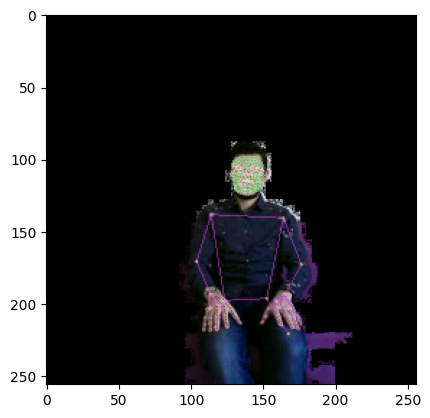

In [24]:
# create train dataset
ld_train = Turkish_Dataset(train_path, train_label)

# show image but clip rbg values
train_img = np.array(np.transpose(ld_train[0][0][0], (1, 2, 0))).astype('uint8')
train_img = cv2.cvtColor(train_img, cv2.COLOR_RGB2BGR)
plt.imshow(train_img)
plt.show()


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


Attempting to access label for: signer10_sample20


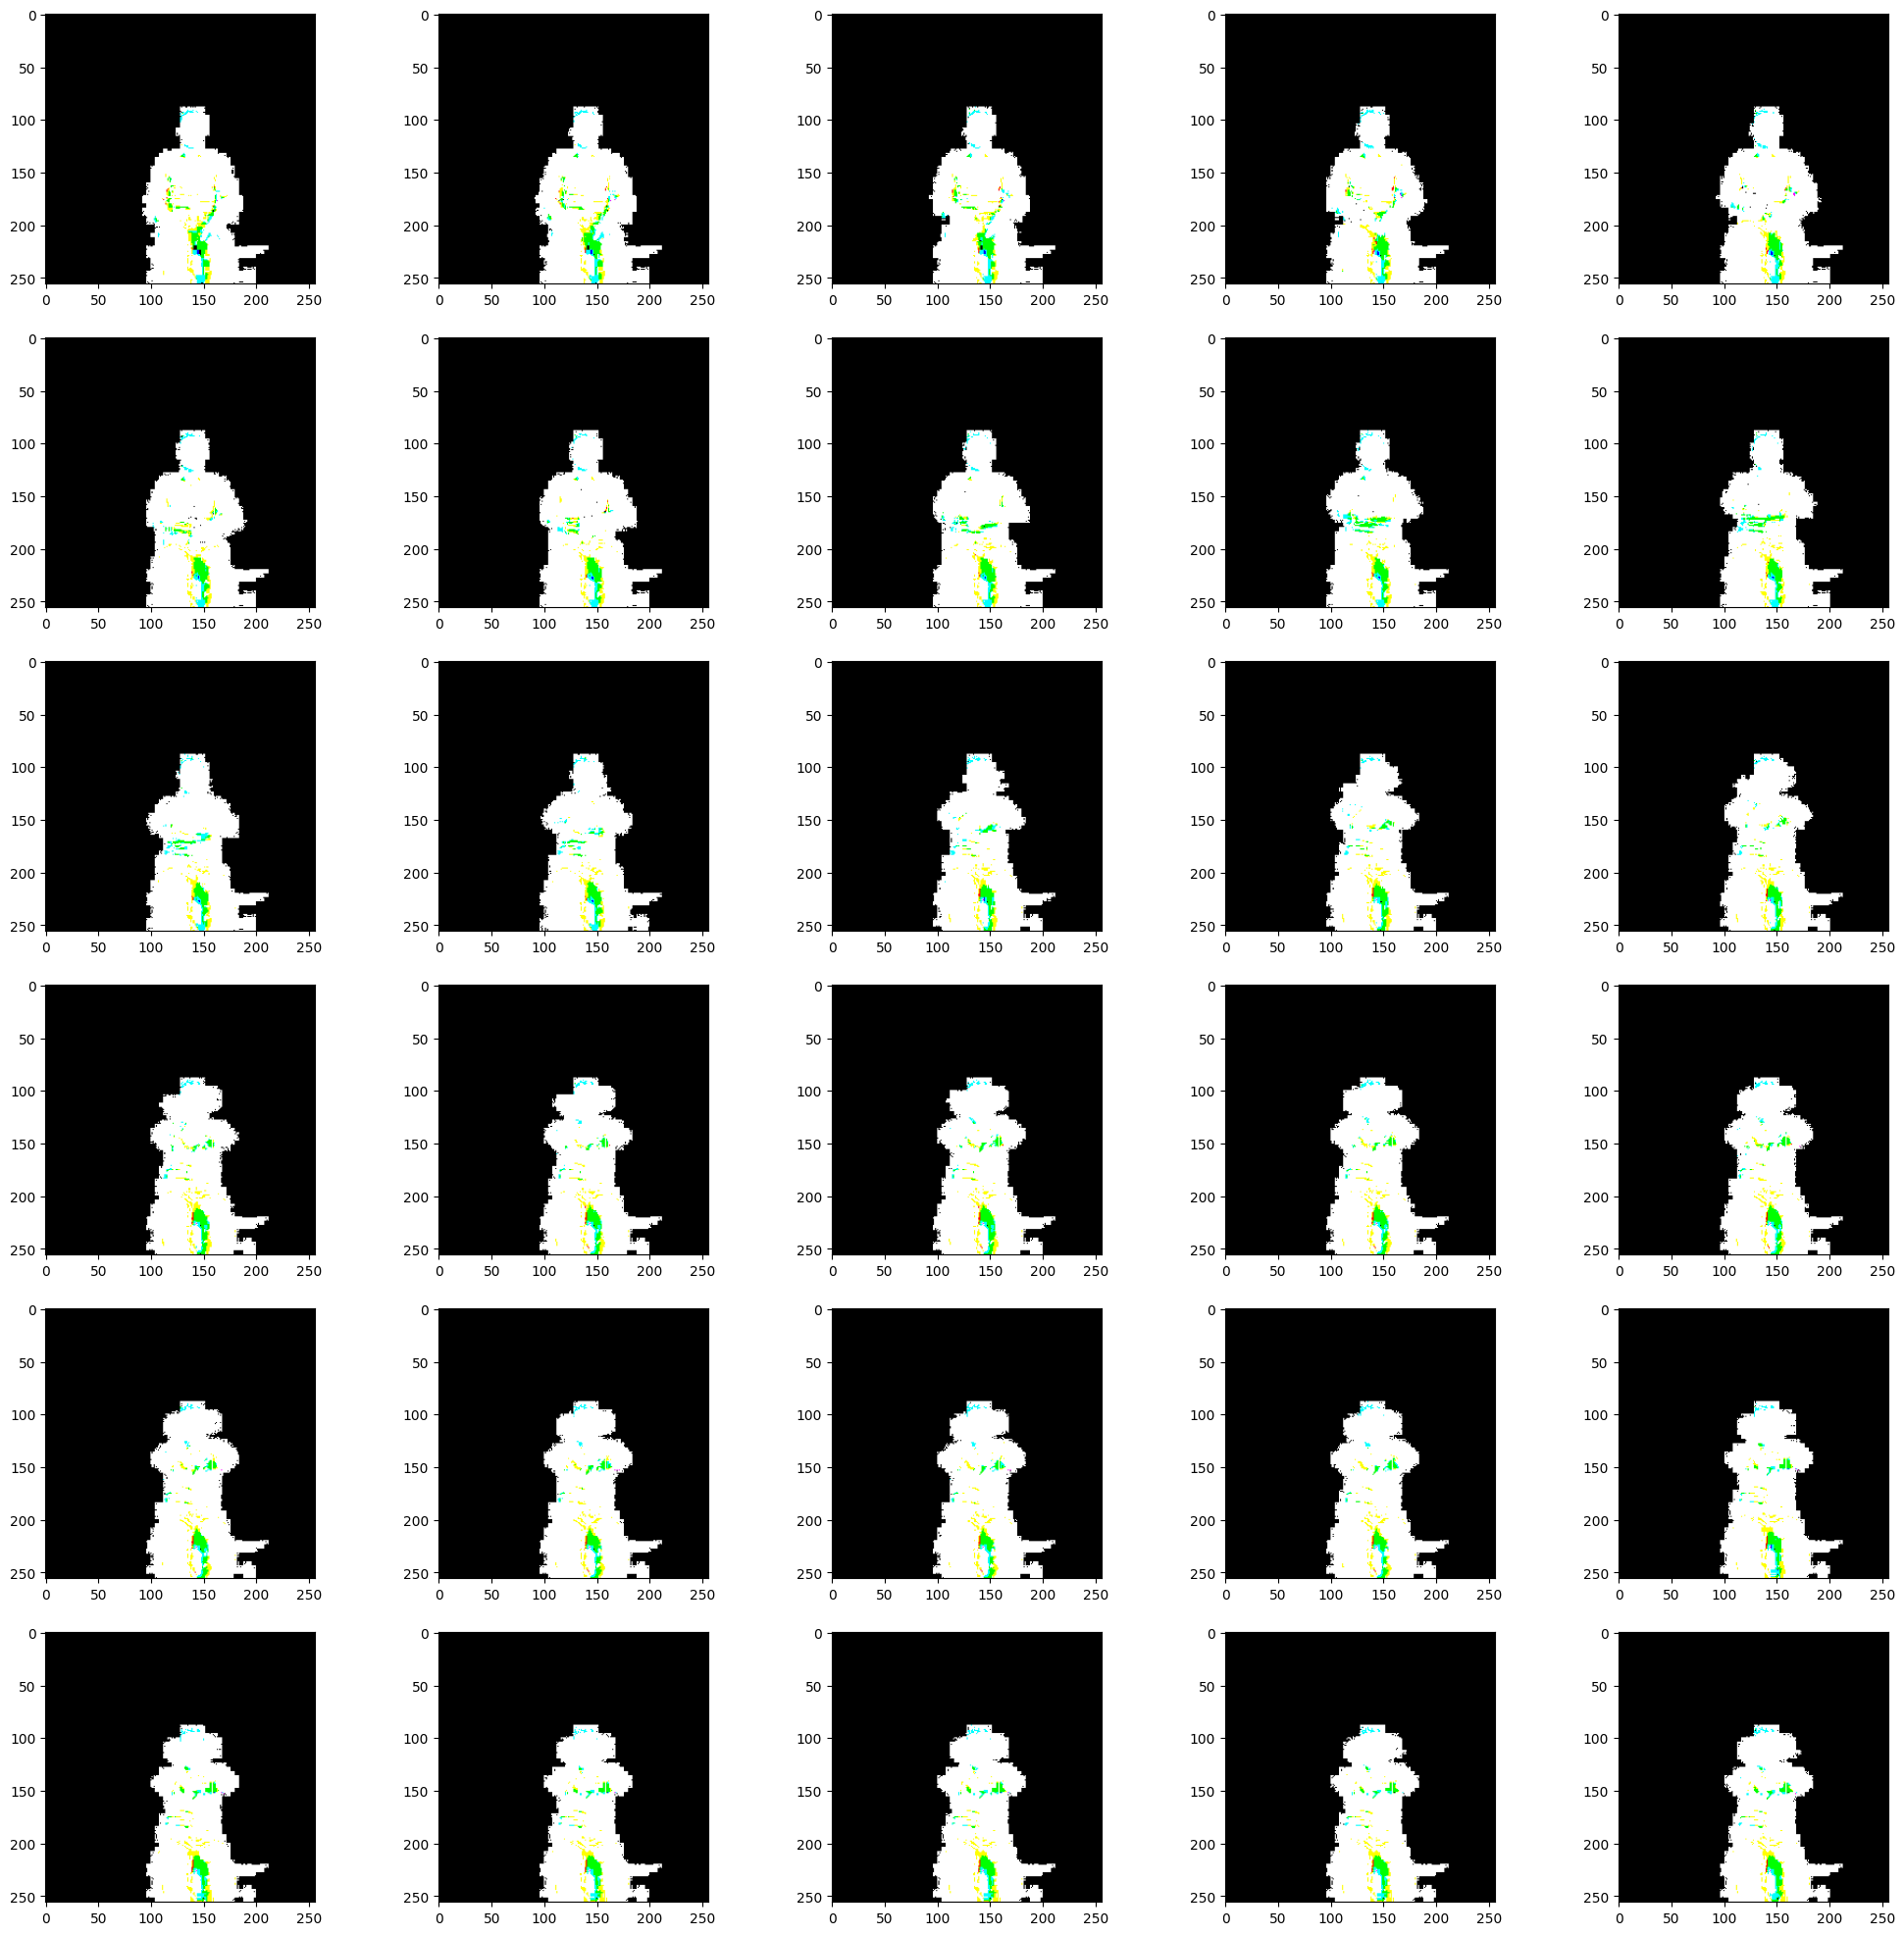

In [25]:
# # UNCOMMENT TO SEE SAMPLED FRAMES
nrows, ncols = 6, 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
for i in range(n_frames):
    row_idx = i // ncols
    col_idx = i % ncols
    ax[row_idx][col_idx].imshow(ld_train[0][0][i].numpy().transpose(1, 2, 0))

# # UNCOMMENT TO SAVE PLOT
# plt.savefig('train_30_0.png')

plt.show()

In [26]:
# # Display the images in the dataset
# import matplotlib.pyplot as plt
# import numpy as np

# n_frames = 30
# nrows, ncols = 6, 5
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))

# for i in range(n_frames):
#     row_idx = i // ncols
#     col_idx = i % ncols

#     # Get the image data and normalize/clamp it
#     img_data = ld_train[0][0][i].numpy().transpose(1, 2, 0)

#     # If img_data is float, normalize it to [0, 1]
#     if img_data.dtype == np.float32 or img_data.dtype == np.float64:
#         img_data = np.clip(img_data, 0, 1)
#     # If img_data is integer, clamp it to [0, 255]
#     elif img_data.dtype == np.uint8:
#         img_data = np.clip(img_data, 0, 255)

#     ax[row_idx][col_idx].imshow(img_data)

# plt.show()


Processing file: /content/drive/MyDrive/data/data/test/signer10_sample18_depth.mp4
Extracted vid_name: signer10_sample18, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/test/signer10_sample15_depth.mp4
Extracted vid_name: signer10_sample15, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/test/signer10_sample16_color.mp4
Extracted vid_name: signer10_sample16, vid_type: color
Processing file: /content/drive/MyDrive/data/data/test/signer10_sample15_color.mp4
Extracted vid_name: signer10_sample15, vid_type: color
Processing file: /content/drive/MyDrive/data/data/test/signer10_sample16_depth.mp4
Extracted vid_name: signer10_sample16, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/test/signer10_sample18_color.mp4
Extracted vid_name: signer10_sample18, vid_type: color
Processing file: /content/drive/MyDrive/data/data/test/signer10_sample17_color.mp4
Extracted vid_name: signer10_sample17, vid_type: color
Processing file: /content/drive/My

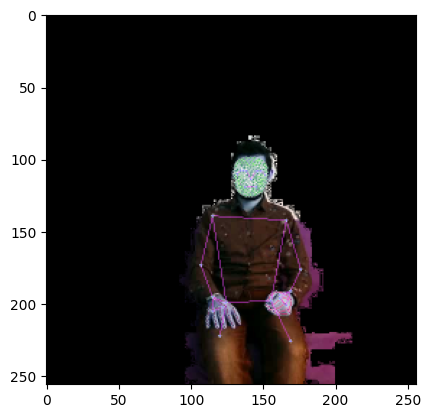

In [27]:
# create test dataset
ld_test = Turkish_Dataset(test_path, test_label)
print("shape of first array", ld_test[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_test[0][0][0].numpy()
img_np_arr -= img_np_arr.min()
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

Processing file: /content/drive/MyDrive/data/data/val/signer10_sample2_color.mp4
Extracted vid_name: signer10_sample2, vid_type: color
Processing file: /content/drive/MyDrive/data/data/val/signer10_sample1_depth.mp4
Extracted vid_name: signer10_sample1, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/val/signer10_sample3_depth.mp4
Extracted vid_name: signer10_sample3, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/val/signer10_sample1_color.mp4
Extracted vid_name: signer10_sample1, vid_type: color
Processing file: /content/drive/MyDrive/data/data/val/signer10_sample2_depth.mp4
Extracted vid_name: signer10_sample2, vid_type: depth
Processing file: /content/drive/MyDrive/data/data/val/signer10_sample3_color.mp4
Extracted vid_name: signer10_sample3, vid_type: color
Processing file: /content/drive/MyDrive/data/data/val/signer0_sample13_color.mp4
Extracted vid_name: signer0_sample13, vid_type: color
Processing file: /content/drive/MyDrive/data/data/val/s

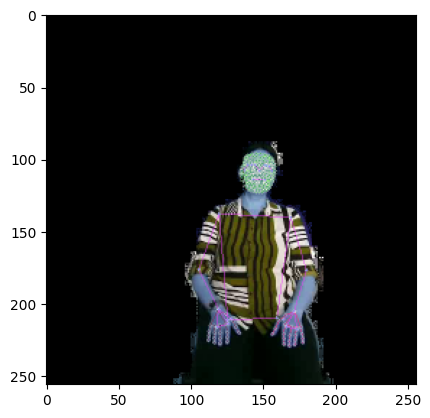

In [28]:
ld_val = Turkish_Dataset(val_path, val_label)
print("shape of first array", ld_val[0][0].shape)

img_np_arr = ld_val[5][0][0].numpy()
img_np_arr -= img_np_arr.min()
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

In [29]:
bs_train = 4
bs_test = 4
bs_val = 4
train_loader = DataLoader(ld_train, batch_size = bs_train, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_test, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

In [108]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet101, vgg11


class ConvBlock(nn.Module):
    """Convolution block used in CNN."""
    def __init__(self,
                 channel_in,
                 channel_out,
                 activation_fn,
                 use_batchnorm,
                 pool:str='max_2',
                 kernel_size:int=3):

        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size)

        self.use_batchnorm = use_batchnorm
        if self.use_batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(channel_out, momentum=0.01)
            self.batchnorm2 = nn.BatchNorm2d(channel_out, momentum=0.01)

        if activation_fn == "relu":
            self.a_fn = nn.ReLU()
        elif activation_fn == "leaky_relu":
            self.a_fn = nn.LeakyReLU()
        elif activation_fn == "param_relu":
            self.a_fn = nn.PReLU()
        else:
            raise ValueError("please use a valid activation function argument ('relu'; 'leaky_relu'; 'param_relu')")

        if pool == "max_2":
            self.pool = nn.MaxPool2d(2)
        elif pool == "adap":
            self.pool = nn.AdaptiveAvgPool2d(1)
        elif not pool:
            self.pool = pool
        else:
            raise ValueError("please use a valid pool argument ('max_2', 'adap', None)")

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batchnorm:
            out = self.batchnorm1(out)
        out = self.a_fn(out)

        out = self.conv2(out)
        if self.use_batchnorm:
            out = self.batchnorm2(out)
        out = self.a_fn(out)
        if self.pool:
            out = self.pool(out)
        return out

class CNN_Encoder(nn.Module):
    """CNN Encoder for CNN part of model."""
    def __init__(self,
                 channel_out,
                 n_layers,
                 intermediate_act_fn="relu",
                 use_batchnorm=True,
                 channel_in=3):

        super(CNN_Encoder, self).__init__()

        channels = [64, 128, 256, 512]

        if n_layers < 1 or n_layers > len(channels)*2:
            raise ValueError(f"please use a valid int for the n_layers param (1-{len(channels)*2})")

        n_repeat = remainder = max(0, n_layers - len(channels))
        pointer = 0

        self.conv1 = nn.Conv2d(channel_in, channels[0], 3, stride=2)
        self.maxpool = nn.MaxPool2d(3, 2)

        layers =  OrderedDict()

        if n_layers > 1:
            layers[str(0)] = ConvBlock(channels[0], channels[0], intermediate_act_fn, use_batchnorm=use_batchnorm)

        for i in range(1, n_layers-1):
            if i % 2 == 0 and remainder > 0:
                layers[str(i)] = ConvBlock(channels[pointer], channels[pointer], intermediate_act_fn, use_batchnorm=use_batchnorm, pool=None)
                remainder -= 1
            else:
                layers[str(i)] = ConvBlock(channels[pointer], channels[min(pointer+1, len(channels)-1)], intermediate_act_fn, use_batchnorm=use_batchnorm)
                pointer += 1

        self.layers = nn.Sequential(layers)
        if n_layers < len(channels):
            conv_to_fc = channels[n_layers-1-n_repeat]
        else:
            conv_to_fc = channels[-1]

        self.conv2 = ConvBlock(channels[n_layers-2-n_repeat], conv_to_fc, intermediate_act_fn, use_batchnorm=use_batchnorm, pool="adap")

        self.fc = nn.Linear(conv_to_fc, channel_out)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layers(out)
        out = self.conv2(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

class LSTM_Decoder(nn.Module):
    """LSTM Decoder for RNN part of model."""
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 channel_out,
                 n_layers,
                 intermediate_act_fn="relu",
                 bidirectional=False,
                 attention=False,
                 device="cuda"):

        super(LSTM_Decoder, self).__init__()

        self.num_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        self.bidirectional = bidirectional
        self.attention = attention

        self.lstm = nn.LSTM(embed_dim,
                            self.hidden_dim,
                            num_layers=self.num_layers,
                            bidirectional=self.bidirectional,
                            batch_first=True)

        if self.bidirectional:
            fc1_in = self.hidden_dim * 2
        else:
            fc1_in = self.hidden_dim
        self.fc1 =  nn.Linear(fc1_in, channel_out)

        if intermediate_act_fn == "relu":
            self.a_fn = nn.ReLU()
        elif intermediate_act_fn == "leaky_relu":
            self.a_fn = nn.LeakyReLU()
        elif intermediate_act_fn == "param_relu":
            self.a_fn = nn.PReLU()
        else:
            raise ValueError("please use a valid activation function argument ('relu'; 'leaky_relu'; 'param_relu')")

        if self.attention:
            self.attention_layer = nn.Linear(2 * self.hidden_dim if self.bidirectional else self.hidden_dim, 1)

    def forward(self, x):

        if self.bidirectional:
            h_0_size = c_0_size = self.num_layers * 2
        else:
            h_0_size = c_0_size = self.num_layers
        h = torch.zeros(h_0_size, x.size(0), self.hidden_dim).to(self.device)
        c = torch.zeros(c_0_size, x.size(0), self.hidden_dim).to(self.device)

        self.lstm.flatten_parameters()

        # Propagate input through LSTM
        out, (h, c) = self.lstm(x, (h, c)) #lstm with input, hidden, and internal state

        if self.attention:
            attention_w = F.softmax(self.attention_layer(out).squeeze(-1), dim=-1)

            out = torch.sum(attention_w.unsqueeze(-1) * out, dim=1)
        else:
            out = out[:, -1, :]

        out = self.fc1(out)

        return out, h

class CNN_LSTM(nn.Module):
    """CNN-LSTM model combining CNN and LSTM components."""
    def __init__(self,
                 n_classes,
                 latent_size,
                 n_cnn_layers,
                 n_rnn_layers,
                 n_rnn_hidden_dim,
                 channel_in=3,
                 cnn_act_fn="relu",
                 rnn_act_fn="relu",
                 dropout_rate=0.1,
                 cnn_bn=False,
                 bidirectional=False,
                 attention=False,
                 device="cuda"):

        super(CNN_LSTM, self).__init__()

        self.attention = attention

        self.encoder = CNN_Encoder(latent_size,
                                   n_cnn_layers,
                                   intermediate_act_fn=cnn_act_fn,
                                   use_batchnorm=cnn_bn,
                                   channel_in=channel_in)
        self.decoder = LSTM_Decoder(latent_size,
                                    n_rnn_hidden_dim,
                                    n_classes,
                                    n_rnn_layers,
                                    intermediate_act_fn=rnn_act_fn,
                                    bidirectional=bidirectional,
                                    attention=attention,
                                    device=device)

        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        cnn_in = x.view(batch_size * timesteps, C, H, W)
        latent_var = self.encoder(cnn_in)

        rnn_in = latent_var.view(batch_size, timesteps, -1)
        rnn_in = self.dropout(rnn_in)
        out, _ = self.decoder(rnn_in)

        return out

class VGG_LSTM(nn.Module):
    """VGG-LSTM model using VGG11 as CNN component."""
    def __init__(self,
                 n_classes,
                 latent_size,
                 n_rnn_layers,
                 n_rnn_hidden_dim,
                 rnn_act_fn="relu",
                 dropout_rate=0.1,
                 bidirectional=False):

        super(VGG_LSTM, self).__init__()

        self.CNN = vgg11(pretrained=True, progress=False)
        self.CNN.classifier[6] = nn.Linear(4096, latent_size)

        self.decoder = LSTM_Decoder(latent_size, n_rnn_hidden_dim, n_classes, n_rnn_layers, intermediate_act_fn=rnn_act_fn, bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        cnn_in = x.view(batch_size * timesteps, C, H, W)
        latent_var = self.CNN(cnn_in)

        rnn_in = latent_var.view(batch_size, timesteps, -1)
        rnn_in = self.dropout(rnn_in)
        out = self.decoder(rnn_in)

        return out

# extra models for experimentation below

class GRU_Decoder(nn.Module):

    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 channel_out,
                 n_layers,
                 intermediate_act_fn="relu",
                 bidirectional=False,
                 device="cuda"):

        super(GRU_Decoder, self).__init__()

        self.num_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        self.bidirectional = bidirectional

        self.gru = nn.GRU(embed_dim,
                            self.hidden_dim,
                            num_layers=self.num_layers,
                            bidirectional=self.bidirectional,
                            batch_first=True)

        if self.bidirectional:
            fc1_in = self.hidden_dim * 2
        else:
            fc1_in = self.hidden_dim
        self.fc1 =  nn.Linear(fc1_in, channel_out)

        if intermediate_act_fn == "relu":
            self.a_fn = nn.ReLU()
        elif intermediate_act_fn == "leaky_relu":
            self.a_fn = nn.LeakyReLU()
        elif intermediate_act_fn == "param_relu":
            self.a_fn = nn.PReLU()
        else:
            raise ValueError("please use a valid activation function argument ('relu'; 'leaky_relu'; 'param_relu')")

    def forward(self, x):

        if self.bidirectional:
            h_0_size = self.num_layers * 2
        else:
            h_0_size = self.num_layers
        h = torch.zeros(h_0_size, x.size(0), self.hidden_dim).to(self.device)

        self.gru.flatten_parameters()

        # Propagate input through LSTM
        output, h = self.gru(x, h) #lstm with input, hidden, and internal state

        out = output[:, -1, :]

        out = self.fc1(out)

        return out

class RNN_Decoder(nn.Module):

    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 channel_out,
                 n_layers,
                 intermediate_act_fn="relu",
                 bidirectional=False,
                 attention=False,
                 device="cuda"):

        super(RNN_Decoder, self).__init__()

        self.num_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        self.bidirectional = bidirectional
        self.attention = attention

        self.rnn = nn.RNN(embed_dim,
                            self.hidden_dim,
                            num_layers=self.num_layers,
                            bidirectional=self.bidirectional,
                            batch_first=True)

        if self.bidirectional:
            fc1_in = self.hidden_dim * 2
        else:
            fc1_in = self.hidden_dim
        self.fc1 =  nn.Linear(fc1_in, channel_out)

        if intermediate_act_fn == "relu":
            self.a_fn = nn.ReLU()
        elif intermediate_act_fn == "leaky_relu":
            self.a_fn = nn.LeakyReLU()
        elif intermediate_act_fn == "param_relu":
            self.a_fn = nn.PReLU()
        else:
            raise ValueError("please use a valid activation function argument ('relu'; 'leaky_relu'; 'param_relu')")

    def forward(self, x):

        if self.bidirectional:
            h_0_size = self.num_layers * 2
        else:
            h_0_size = self.num_layers
        h = torch.zeros(h_0_size, x.size(0), self.hidden_dim).to(self.device)

        self.rnn.flatten_parameters()

        # Propagate input through LSTM
        out, h = self.rnn(x, h) #lstm with input, hidden, and internal state

        if not self.attention:
            out = out[:, -1, :]
            out = self.fc1(out)

        return out, h

class CNN_GRU(nn.Module):

    def __init__(self,
                 n_classes,
                 latent_size,
                 n_cnn_layers,
                 n_rnn_layers,
                 n_rnn_hidden_dim,
                 channel_in=3,
                 cnn_act_fn="relu",
                 rnn_act_fn="relu",
                 dropout_rate=0.1,
                 cnn_bn=False,
                 bidirectional=False):

        super(CNN_GRU, self).__init__()

        self.encoder = CNN_Encoder(latent_size, n_cnn_layers, intermediate_act_fn=cnn_act_fn, use_batchnorm=cnn_bn, channel_in=channel_in)
        self.decoder = GRU_Decoder(latent_size, n_rnn_hidden_dim, n_classes, n_rnn_layers, intermediate_act_fn=rnn_act_fn, bidirectional=bidirectional)

        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):

        batch_size, timesteps, C, H, W = x.size()

        cnn_in = x.view(batch_size * timesteps, C, H, W)
        latent_var = self.encoder(cnn_in)

        rnn_in = latent_var.view(batch_size, timesteps, -1)
        rnn_in = self.dropout(rnn_in)
        out = self.decoder(rnn_in)

        return out

class CNN_RNN(nn.Module):

    def __init__(self,
                 n_classes,
                 latent_size,
                 n_cnn_layers,
                 n_rnn_layers,
                 n_rnn_hidden_dim,
                 channel_in=3,
                 cnn_act_fn="relu",
                 rnn_act_fn="relu",
                 dropout_rate=0.1,
                 cnn_bn=False,
                 bidirectional=False):

        super(CNN_RNN, self).__init__()

        self.encoder = CNN_Encoder(latent_size, n_cnn_layers, intermediate_act_fn=cnn_act_fn, use_batchnorm=cnn_bn, channel_in=channel_in)
        self.decoder = RNN_Decoder(latent_size, n_rnn_hidden_dim, n_classes, n_rnn_layers, intermediate_act_fn=rnn_act_fn, bidirectional=bidirectional)

        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):

        batch_size, timesteps, C, H, W = x.size()

        cnn_in = x.view(batch_size * timesteps, C, H, W)
        latent_var = self.encoder(cnn_in)

        rnn_in = latent_var.view(batch_size, timesteps, -1)
        rnn_in = self.dropout(rnn_in)
        out = self.decoder(rnn_in)

        return out

class ResNet_LSTM(nn.Module):

    def __init__(self,
                 n_classes,
                 latent_size,
                 n_rnn_layers,
                 channel_in=3,
                 rnn_act_fn="relu",
                 bidirectional=False,
                 resnet_opt="resnet18"):

        super(ResNet_LSTM, self).__init__()

        if resnet_opt == "resnet18":
            self.CNN = resnet18(pretrained=True)
        elif resnet_opt == "resnet101":
            self.CNN = resnet101(pretrained=True)

        self.CNN.fc = nn.Sequential(nn.Linear(self.CNN.fc.in_features, latent_size))

        self.LSTM = LSTM_Decoder(latent_size, 3, n_classes, n_rnn_layers, intermediate_act_fn=rnn_act_fn, bidirectional=bidirectional)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        cnn_in = x.view(batch_size * timesteps, C, H, W)
        latent_var = self.CNN(cnn_in)

        rnn_in = latent_var.view(batch_size, timesteps, -1)
        out = self.RNN(rnn_in)

        out = self.softmax(out)
        return out

In [31]:
model = CNN_LSTM(u_len_label,
                 latent_size=512,
                 n_cnn_layers=6,
                 n_rnn_layers=1,
                 n_rnn_hidden_dim=512,
                 cnn_bn=True,
                 bidirectional=True,
                 dropout_rate=0.8,
                 attention=True)
summary(model, input_size=(4, 30, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [4, 226]                  --
├─CNN_Encoder: 1-1                       [120, 512]                --
│    └─Conv2d: 2-1                       [120, 64, 127, 127]       1,792
│    └─Sequential: 2-2                   [120, 256, 6, 6]          --
│    │    └─ConvBlock: 3-1               [120, 64, 61, 61]         74,112
│    │    └─ConvBlock: 3-2               [120, 128, 28, 28]        221,952
│    │    └─ConvBlock: 3-3               [120, 128, 24, 24]        295,680
│    │    └─ConvBlock: 3-4               [120, 256, 10, 10]        886,272
│    │    └─ConvBlock: 3-5               [120, 256, 6, 6]          1,181,184
│    └─ConvBlock: 2-3                    [120, 512, 1, 1]          --
│    │    └─Conv2d: 3-6                  [120, 512, 4, 4]          1,180,160
│    │    └─BatchNorm2d: 3-7             [120, 512, 4, 4]          1,024
│    │    └─ReLU: 3-8                    [120,

In [32]:
# hyperparams
no_of_epochs = 20
optimizer_lr = 1e-5
save_dir = "/content"

In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).float().sum()
    accuracy = correct / labels.shape[0]
    return accuracy.item()

def train(model, train_loader, val_loader, no_of_epochs, logger, writer, save_dir, save_checkpoint=True, device='cuda', patience=10, optimizer_lr=0.001, use_scheduler=True, log_interval=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=optimizer_lr)

    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience // 2, factor=0.5)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(no_of_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        logger.info(f'Starting epoch {epoch+1}/{no_of_epochs}')

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

            if batch_idx % log_interval == 0:
                logger.info(f'Epoch {epoch+1}/{no_of_epochs} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        logger.info(f'Epoch {epoch+1}/{no_of_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
        writer.add_scalar('Training Loss', epoch_loss, epoch)
        writer.add_scalar('Training Accuracy', epoch_acc, epoch)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects / len(val_loader.dataset)
        logger.info(f'Epoch {epoch+1}/{no_of_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')
        writer.add_scalar('Validation Loss', epoch_val_loss, epoch)
        writer.add_scalar('Validation Accuracy', epoch_val_acc, epoch)

        if use_scheduler:
            scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            if save_checkpoint:
                model_save_path = os.path.join(save_dir, f'best_model_epoch_{epoch+1}.pth')
                torch.save(model.state_dict(), model_save_path)
                logger.info(f'Saved best model at epoch {epoch+1} with validation loss: {epoch_val_loss:.4f}')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                logger.info(f'Early stopping at epoch {epoch+1}')
                break

    # Save the final model
    final_model_path = os.path.join(save_dir, 'final_model.pth')
    torch.save(model.state_dict(), final_model_path)
    logger.info(f'Final model saved at {final_model_path}')

    logger.info('Training complete')

In [34]:
train(model,
      train_loader,
      val_loader,
      no_of_epochs,
      logger,
      writer,
      save_dir=save_dir,
      save_checkpoint=True,
      device=device,
      patience=10,
      optimizer_lr=optimizer_lr,
      use_scheduler=True)



Attempting to access label for: signer10_sample21
Attempting to access label for: signer10_sample13
Attempting to access label for: signer10_sample14
Attempting to access label for: signer0_sample2


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Attempting to access label for: signer0_sample4
Attempting to access label for: signer0_sample3
Attempting to access label for: signer10_sample11
Attempting to access label for: signer10_sample23
Attempting to access label for: signer10_sample10
Attempting to access label for: signer10_sample20
Attempting to access label for: signer0_sample1
Attempting to access label for: signer10_sample22
Attempting to access label for: signer10_sample24
Attempting to access label for: signer10_sample12
Attempting to access label for: signer0_sample5
Attempting to access label for: signer10_sample25
Attempting to access label for: signer0_sample15
Attempting to access label for: signer10_sample1
Attempting to access label for: signer10_sample2
Attempting to access label for: signer0_sample13
Attempting to access label for: signer0_sample12
Attempting to access label for: signer0_sample14
Attempting to access label for: signer10_sample3
Attempting to access label for: signer0_sample11
Attempting to ac

In [99]:
!pip install gdown torch torchvision matplotlib pandas av opencv-python


In [105]:
import gdown

# Download the model file
model_url = 'https://drive.google.com/uc?id=1m2zHzo19Yvqd_-bdAxrSbTCD7IYqLDzT'
model_path = '/content/final_model.pth'
gdown.download(model_url, model_path, quiet=False)

# Download the test data
test_data_url = 'https://drive.google.com/uc?id=1ATO4wdMimxa4sQ3Oh3zWU3LoPH9XkN7r'
output_path = '/content/test.mp4'
gdown.download(test_data_url, output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1m2zHzo19Yvqd_-bdAxrSbTCD7IYqLDzT
From (redirected): https://drive.google.com/uc?id=1m2zHzo19Yvqd_-bdAxrSbTCD7IYqLDzT&confirm=t&uuid=247b18a4-2d23-4b0f-b438-8998465075e9
To: /content/final_model.pth
100%|██████████| 43.7M/43.7M [00:00<00:00, 62.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ATO4wdMimxa4sQ3Oh3zWU3LoPH9XkN7r
To: /content/test.mp4
100%|██████████| 340k/340k [00:00<00:00, 117MB/s]


'/content/test.mp4'

Predicted Label: tensor([41], device='cuda:0')


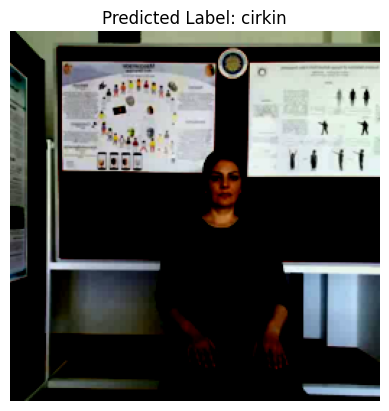

In [112]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import av
import cv2

model_path = '/content/final_model.pth'
model = CNN_LSTM(u_len_label,
                 latent_size=512,
                 n_cnn_layers=6,
                 n_rnn_layers=1,
                 n_rnn_hidden_dim=512,
                 cnn_bn=True,
                 bidirectional=True,
                 dropout_rate=0.8,
                 attention=True)
model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

label_mapping_df = pd.read_csv('/content/ClassId.csv')
label_mapping = dict(zip(label_mapping_df['ClassId'], label_mapping_df['TR']))

transforms_compose = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def extract_frames(vid, frames_cap=30):
    selector = fix_frame(len(vid), frames_cap)
    output = []
    for e, frame in enumerate(vid):
        if e + 1 in selector:
            output.append(frame)
    if len(vid) < frames_cap:
        remainder = frames_cap - len(vid)
        last_frame = vid[-1]
        for _ in range(remainder):
            output.append(last_frame)
    return output

def load_video(video_path):
    container = av.open(video_path)
    frames = [frame.to_image() for frame in container.decode(video=0)]
    frames = [transforms_compose(frame) for frame in frames]
    return extract_frames(frames)

sample_video_path = '/content/test.mp4'

sample_video = load_video(sample_video_path)
sample_video = torch.stack(sample_video).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(sample_video)
    _, predicted = torch.max(output, 1)

predicted_label = label_mapping[predicted.item()]

print(f'Predicted Label: {predicted}')

plt.imshow(sample_video[0, 0].permute(1, 2, 0).cpu().numpy())
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()
